<a href="https://colab.research.google.com/github/bieri2/ATMS597_Project5_GroupB/blob/master/Project_5_Logistic_Regression_DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import neccessary libraries
from datetime import datetime
import pandas as pd
import numpy as np
!pip install metpy
from metpy.io import parse_metar_to_dataframe
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
import seaborn as sns; sns.set()
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

     |████████████████████████████████| 327kB 2.8MB/s 
     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 


Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [3]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#change to your directory where you stored the files
%cd /content/drive/My Drive/Project_5/

/content/drive/My Drive/Project_5


In [5]:
# Read the qc csv for KDSM
data = pd.read_csv('all_data_KDSM_qc.csv', index_col='date_time', 
                   parse_dates=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#select the columns that have useful information (i.e., not the empty columns)
df=data[['wind_direction', 'wind_speed', 'current_wx1','low_cloud_type',
      'low_cloud_level','medium_cloud_level','medium_cloud_type',
       'medium_cloud_level', 'high_cloud_type', 'high_cloud_level',
       'highest_cloud_type', 'highest_cloud_level', 'cloud_coverage',
       'air_temperature', 'dew_point_temperature', 'altimeter',
       'present_weather', 'past_weather', 'eastward_wind', 'northward_wind']]

In [7]:
# check to see how many different weather types
df.current_wx1.unique()

array(['BR', 'FZDZ', '-RA', '-SN', 'HZ', 'FG', '-FZRA', 'FZFG', 'SN',
       '+SN', 'RA', '+TSRA', 'TSRA', '-TSRA', 'TS', '+RA', '+TS', 'BL',
       '-FZDZ', '-SNRA', 'FZRA', 'SNRA', 'BLDU', 'MIFG', '+FZRA', 'VCTS',
       '-SNDZ', '-TS', 'VCFG', '-TSDZ'], dtype=object)

In [0]:
# change current_wx to binary with respect to rain/snow
# while set 0 to rain 1 to snow
wx_binary ={'-RA':0, '-SN':1,'SN':1,'+SN':1,'RA':0,'+TSRA':0,'TSRA':0,'-TSRA':0,
            '+RA':0,'-FZDZ':0,'FZRA':0,'+FZRA':0,'-TSDZ':0}


In [9]:
# remap the column with the binary values
df.loc[:,'wx_binary']=df['current_wx1'].map(wx_binary) 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# keep the rows where wx_binary is not np.nan
df_new=df[~np.isnan(df['wx_binary'])]
df_new.to_csv('KDSM_metar_new.csv')

,wind_direction,wind_speed,current_wx1,low_cloud_type,low_cloud_level,medium_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,eastward_wind,northward_wind,wx_binary
date_time,,,,,,,,,,,,,,,,,,,,,
2000-01-03 18:10:00,40.0,10.0,-RA,OVC,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1.0,0.0,29.86,61,10,-6.427876,-7.660444,0.0
2000-01-03 18:15:00,30.0,10.0,-RA,OVC,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1.0,0.0,29.86,61,10,-5.000000,-8.660254,0.0
2000-01-03 18:20:00,30.0,9.0,-RA,OVC,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1.0,0.0,29.86,61,10,-4.500000,-7.794229,0.0
2000-01-03 18:25:00,40.0,8.0,-RA,OVC,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1.0,0.0,29.86,61,10,-5.142301,-6.128356,0.0
2000-01-03 18:30:00,30.0,9.0,-RA,OVC,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1.0,0.0,29.86,61,10,-4.500000,-7.794229,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29 09:50:00,290.0,22.0,-RA,BKN,1500.0,2300.0,OVC,2300.0,NaN,NaN,NaN,NaN,8,4.0,3.0,29.56,61,0,20.673238,-7.524443,0.0
2020-03-29 09:55:00,290.0,18.0,-RA,BKN,1300.0,1900.0,OVC,1900.0,NaN,NaN,NaN,NaN,8,4.0,3.0,29.57,61,0,16.914467,-6.156363,0.0
2020-03-29 10:00:00,290.0,25.0,-RA,SCT,1300.0,1900.0,OVC,1900.0,NaN,NaN,NaN,NaN,8,4.0,3.0,29.57,61,0,23.492316,-8.550504,0.0


## Logistic Regression Model

In [0]:
#choose features from the new metar dataframe
features = df_new[['wind_direction', 'wind_speed','low_cloud_type',
      'low_cloud_level', 'cloud_coverage',
       'air_temperature', 'dew_point_temperature', 'altimeter',
       'present_weather', 'eastward_wind', 'northward_wind','wx_binary']]

In [63]:
#list the different low_cloud_types
features['low_cloud_type'].unique()

array(['OVC', 'BKN', 'FEW', 'SCT', 'VV', nan, 'CLR'], dtype=object)

In [0]:
# convert the low_cloud_type to a value between 0 to 1
lc_flt ={'OVC':1, 'BKN':0.75, 'FEW':0.2, 'SCT':0.4, 'CLR':0}

In [65]:
# remap the low_cloud_type column with the decimal values
features['low_cloud_type']=features['low_cloud_type'].map(lc_flt) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# drop nan from features
features=features.dropna()

In [0]:
# add a time_of_day to the feature
features['time_of_day']=features.index.hour

In [68]:
features

,wind_direction,wind_speed,low_cloud_type,low_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,eastward_wind,northward_wind,wx_binary,time_of_day
date_time,,,,,,,,,,,,,
2000-01-03 18:10:00,40.0,10.0,1.00,500.0,8,1.0,0.0,29.86,61,-6.427876,-7.660444,0.0,18
2000-01-03 18:15:00,30.0,10.0,1.00,500.0,8,1.0,0.0,29.86,61,-5.000000,-8.660254,0.0,18
2000-01-03 18:20:00,30.0,9.0,1.00,500.0,8,1.0,0.0,29.86,61,-4.500000,-7.794229,0.0,18
2000-01-03 18:25:00,40.0,8.0,1.00,500.0,8,1.0,0.0,29.86,61,-5.142301,-6.128356,0.0,18
2000-01-03 18:30:00,30.0,9.0,1.00,500.0,8,1.0,0.0,29.86,61,-4.500000,-7.794229,0.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29 09:50:00,290.0,22.0,0.75,1500.0,8,4.0,3.0,29.56,61,20.673238,-7.524443,0.0,9
2020-03-29 09:55:00,290.0,18.0,0.75,1300.0,8,4.0,3.0,29.57,61,16.914467,-6.156363,0.0,9
2020-03-29 10:00:00,290.0,25.0,0.40,1300.0,8,4.0,3.0,29.57,61,23.492316,-8.550504,0.0,10


In [0]:
features.to_csv('logistic_features_new.csv')

In [0]:
# features setup
y = features['wx_binary']
X = features.drop(['wx_binary'],axis=1).values

In [0]:
#Split the data into training and testing data with 0.7 and 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state=0)

In [0]:
#scale the X data 
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

In [0]:
#intialize the logistic regression and fit the regression to training data
clf = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)

In [0]:
#calculate the probability for logistic regression
test_prob = clf.predict_proba(X_test_scaled)
train_prob = clf.predict_proba(X_train_scaled)

In [0]:
#function to return the climatological probability
def get_climo(y, shape):
    climo = (np.size((y == 1).values.nonzero()))/float(np.size(y))
    prob  = np.zeros((shape))
    prob[:,0] = 1-climo
    prob[:,1] = climo

    return prob

In [0]:
# calculate climatological probability for training and testing data
train_climo_prob = get_climo(y_train, train_prob.shape)
test_climo_prob = get_climo(y_test, test_prob.shape)

In [0]:
#calculate the Brier Skill Score for training and testing data
train_bss = 1 - (brier_score_loss(y_train, train_prob[:,1])/brier_score_loss(y_train, train_climo_prob[:,1]))
test_bss = 1 - (brier_score_loss(y_test, test_prob[:,1])/brier_score_loss(y_test, test_climo_prob[:,1]))

In [80]:
print('Training Brier skill score: ' + str(train_bss))
print('Validation Brier skill score: ' + str(test_bss))

Training Brier skill score: 0.9366998007102564
Validation Brier skill score: 0.9356258096796903


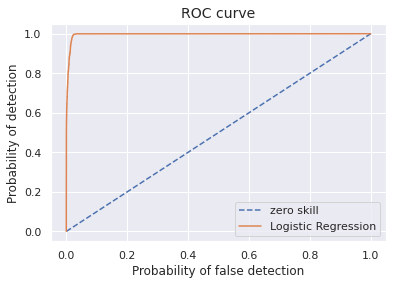

In [60]:
#ploting the roc_curve
plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, test_prob[:,1])
plt.plot([0, 1], [0, 1], linestyle='--',label = 'zero skill')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('Probability of false detection')
plt.ylabel('Probability of detection')
plt.title('ROC curve', fontsize = 14)
plt.legend(loc = 'best')
# show the plot
plt.show()
plt.show()



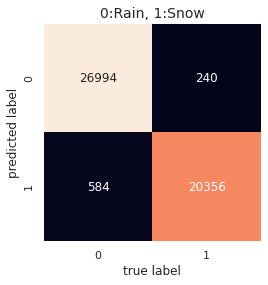

In [61]:
#plot the confusion matrix
mat = confusion_matrix(y_test, predict_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.title('0:Rain, 1:Snow', fontsize = 14)
plt.xlabel('true label')
plt.ylabel('predicted label');